# Kinase Cascade Model
Adapted from a portion of the model published in:

Input-output behavior of ErbB signaling pathways as revealed by a mass action
model trained against dynamic data. William W Chen, Birgit Schoeberl, Paul J
Jasper, Mario Niepel, Ulrik B Nielsen, Douglas A Lauffenburger & Peter K
Sorger. Mol Syst Biol. 2009;5:239. Epub 2009 Jan 20. doi:10.1038/msb.2008.74

http://www.nature.com/msb/journal/v5/n1/full/msb200874.html

Implemented by: Jeremy Muhlich

In [2]:
from pysb import *
from pysb.macros import catalyze_state

Model()

Monomer('Ras', ['k'])
Annotation(Ras, 'http://identifiers.org/uniprot/P01116', 'hasPart')
Annotation(Ras, 'http://identifiers.org/uniprot/P01112', 'hasPart')
Annotation(Ras, 'http://identifiers.org/uniprot/P01111', 'hasPart')
Monomer('Raf', ['s', 'k'], {'s': ['u', 'p']})
Annotation(Raf, 'http://identifiers.org/uniprot/P15056', 'hasPart')
Annotation(Raf, 'http://identifiers.org/uniprot/P04049', 'hasPart')
Annotation(Raf, 'http://identifiers.org/uniprot/P10398', 'hasPart')
Monomer('MEK', ['s218', 's222', 'k'], {'s218': ['u', 'p'], 's222': ['u', 'p']})
Annotation(MEK, 'http://identifiers.org/uniprot/Q02750', 'hasPart')
Annotation(MEK, 'http://identifiers.org/uniprot/P36507', 'hasPart')
Monomer('ERK', ['t185', 'y187'], {'t185': ['u', 'p'], 'y187': ['u', 'p']})
Annotation(ERK, 'http://identifiers.org/uniprot/P27361', 'hasPart')
Annotation(ERK, 'http://identifiers.org/uniprot/P28482', 'hasPart')
Monomer('PP2A', ['ppt'])
Annotation(PP2A, 'http://identifiers.org/mesh/24544')
Monomer('MKP', ['ppt'])
Annotation(MKP, 'http://identifiers.org/mesh/24536')

# Use generic rates for forward/reverse binding and kinase/phosphatase catalysis
kf_bind = 1e-5
kr_bind = 1e-1
kcat_phos = 1e-1
kcat_dephos = 3e-3

# Build handy rate "sets"
klist_bind = [kf_bind, kr_bind]
klist_phos = klist_bind + [kcat_phos]
klist_dephos = klist_bind + [kcat_dephos]

def mapk_single(kinase, pptase, substrate, site):
    """Kinase phos/dephosphorylation."""
    ppt_substrate = substrate()
    if 'k' in ppt_substrate.monomer.sites:
        # Ensure substrates which are themselves kinases don't get
        # dephosphorylated while they are bound to *their* substrate.
        ppt_substrate = ppt_substrate(k=None)
    components = catalyze_state(kinase, 'k',
                                substrate, site, site, 'u', 'p',
                                klist_phos)
    components |= catalyze_state(pptase, 'ppt',
                                 ppt_substrate, site, site, 'p', 'u',
                                 klist_dephos)
    return components

def mapk_double(kinase, pptase, substrate, site1, site2):
    """Distributive + ordered double kinase phos/dephosphorylation."""
    components = mapk_single(kinase, pptase, substrate({site2: 'u'}), site1)
    components |= mapk_single(kinase, pptase, substrate({site1: 'p'}), site2)
    return components

# Ras-Raf-MEK-ERK kinase cascade
mapk_single(Ras, PP2A, Raf, 's')
mapk_double(Raf(s='p'), PP2A, MEK, 's218', 's222')
mapk_double(MEK(s218='p', s222='p'), MKP, ERK, 't185', 'y187')

Initial(Ras(k=None), Parameter('Ras_0', 6e4))
Initial(Raf(s='u', k=None), Parameter('Raf_0', 7e4))
Initial(MEK(s218='u', s222='u', k=None), Parameter('MEK_0', 3e6))
Initial(ERK(t185='u', y187='u'), Parameter('ERK_0', 7e5))
Initial(PP2A(ppt=None), Parameter('PP2A_0', 2e5))
Initial(MKP(ppt=None), Parameter('MKP_0', 1.7e4))

Observable('ppMEK', MEK(s218='p', s222='p'))
Observable('ppERK', ERK(t185='p', y187='p'))

Observable('ppERK', ERK(t185='p', y187='p'))

## Simulation

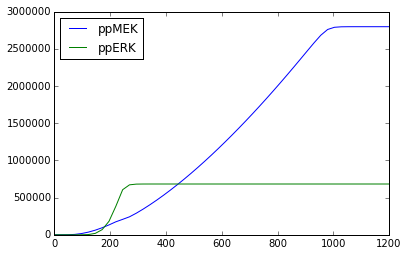

In [3]:
%matplotlib inline
from pysb.integrate import odesolve
from pylab import linspace, plot, legend, show

tspan = linspace(0, 1200)
yfull = odesolve(model, tspan)
plot(tspan, yfull['ppMEK'], label='ppMEK')
plot(tspan, yfull['ppERK'], label='ppERK')
legend(loc='upper left')